# 3. Classify Detected Nodules in LIDC Dataset as FP or TP

## Summary

* Load processed data into trained u-net to generate predicted nodule masks
* Use nodule coordinates file (list3_2.csv) to label detected nodules as TP or FP
* Load images for each respective detected nodule and train a CNN with the TP or FP labels

In [6]:
#EDIT HERE##############################

list32file="LIDC/list3.2.csv"
metafile="LIDC/LIDC-IDRI_MetaData.csv"
unetweightspath="modelweights/unet-weights-improvement.hdf5"
truenoduleweightspath="modelweights/truenodule-cnn-weights-improvement.hdf5"
datafolder="processeddata"
DOIpath='LIDC/DOI/'
########################################


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import dicom
import os
import scipy.ndimage
import time
from keras.callbacks import ModelCheckpoint
import h5py
from sklearn.cluster import KMeans
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import cell_magic_wand as cmw
from glob import glob
import random
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, SpatialDropout2D
from keras.layers import Input, merge, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.models import Sequential
from keras import backend as K
from keras.optimizers import Adam
K.set_image_dim_ordering('th') 
nodulelocations=pd.read_csv(list32file)
meta=pd.read_csv(metafile)

meta=meta.drop(meta[meta['Modality']!='CT'].index)
meta=meta.reset_index()

#Get folder names of CT data for each patient
patients=[DOIpath+meta['Patient Id'][i] for i in range(len(meta))]
datfolder=[]
for i in range(0,len(meta)-1):
    for path in os.listdir(patients[i]):
        if os.path.exists(patients[i]+'/'+path+'/'+meta['Series UID'][i]):
            datfolder.append(patients[i]+'/'+path+'/'+meta['Series UID'][i])
patients=datfolder

#Load nodules locations

#Code sourced from https://www.kaggle.com/c/data-science-bowl-2017#tutorial
smooth = 1.0
width = 32

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet_model():
    inputs = Input((1, 512, 512))
    conv1 = Conv2D(width, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = BatchNormalization(axis = 1)(conv1)
    conv1 = Conv2D(width, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(width*2, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = BatchNormalization(axis = 1)(conv2)
    conv2 = Conv2D(width*2, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(width*4, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = BatchNormalization(axis = 1)(conv3)
    conv3 = Conv2D(width*4, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(width*8, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = BatchNormalization(axis = 1)(conv4)
    conv4 = Conv2D(width*8, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(width*16, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = BatchNormalization(axis = 1)(conv5)
    conv5 = Conv2D(width*16, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = SpatialDropout2D(0.35)(up6)
    conv6 = Conv2D(width*8, 3, 3, activation='relu', border_mode='same')(conv6)
    conv6 = Conv2D(width*8, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = SpatialDropout2D(0.35)(up7)
    conv7 = Conv2D(width*4, 3, 3, activation='relu', border_mode='same')(conv7)
    conv7 = Conv2D(width*4, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = SpatialDropout2D(0.35)(up8)
    conv8 = Conv2D(width*2, 3, 3, activation='relu', border_mode='same')(conv8)
    conv8 = Conv2D(width*2, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = SpatialDropout2D(0.35)(up9)
    conv9 = Conv2D(width, 3, 3, activation='relu', border_mode='same')(conv9)
    conv9 = Conv2D(width, 3, 3, activation='relu', border_mode='same')(conv9)
    conv10 = Conv2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    return model

model=unet_model()
model.load_weights(unetweightspath)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:75: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`

In [2]:
# Load the scans in given folder path
# code sourced from https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s, force=True) for s in os.listdir(path) if s.endswith('.dcm')]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]), reverse=True)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

#convert to ndarray
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def processimage(img):
    #function sourced from https://www.kaggle.com/c/data-science-bowl-2017#tutorial
    #Standardize the pixel values
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    #plt.hist(img.flatten(),bins=200)
    #plt.show()
    #print(thresh_img[366][280:450])
    middle = img[100:400,100:400] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    #move the underflow bins
    img[img==max]=mean
    img[img==min]=mean
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
    eroded = morphology.erosion(thresh_img,np.ones([4,4]))
    dilation = morphology.dilation(eroded,np.ones([10,10]))
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    #plt.imshow(labels)
    #plt.show()
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
            good_labels.append(prop.label)
    mask = np.ndarray([512,512],dtype=np.int8)
    mask[:] = 0
    #
    #  The mask here is the mask for the lungs--not the nodes
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    return mask*img

def processimagefromfile(ppix):
    processpix=np.ndarray([ppix.shape[0],512,512])
    for i in range(ppix.shape[0]):
        processpix[i]=processimage(ppix[i])
    return processpix

#predict mask from images
def predictmask(images):
    images=images.reshape(images.shape[0],1,512,512)
    num_test=images.shape[0]
    imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
    for i in range(num_test):
        imgs_mask_test[i] = model.predict([images[i:i+1]], verbose=0)[0]
    return imgs_mask_test

#find number of slices where a nodule is detected
def getnoduleindex(imgs_mask_test):
    masksum=[np.sum(maskslice[0]) for maskslice in imgs_mask_test]
    return [i for i in range(len(masksum)) if masksum[i]>5]

def nodule_coordinates(nodulelocations,meta):
    slices=nodulelocations["slice no."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    xlocs=nodulelocations["x loc."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    ylocs=nodulelocations["y loc."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    nodulecoord=[]
    for i in range(len(slices)):
        nodulecoord.append([slices.values[i]-1,xlocs.values[i]-1,ylocs.values[i]-1])
    return nodulecoord

#generate nodule or non-nodule labels for mask predictions
def truenodules(noduleindex,masks,nodulecoords):
    label=[]
    for ind in noduleindex:
        for cord in nodulecoords:
            if abs(ind-cord[0])<2:
                com=scipy.ndimage.center_of_mass(masks[ind])
                if abs(com[1]-cord[2])<2 and abs(com[2]-cord[1])<2:
                    label.append(True)
            else:
                label.append(False)
    return label
    
def slicecount(start,end):
    slicecounts=[]
    for i in range(start,end):
        if len(nodule_coordinates(nodulelocations,meta.iloc[i]))>0:
            patient_scan=load_scan(patients[i])
            slicecounts.append(len(patient_scan))
    return slicecounts

In [3]:
#maskedtumor=pix_resampled[int(coord[0])]*cmw_patient
start_time=time.time()
elapsed_time=0
totaltime=50000
noduleimages=np.ndarray([10000,512,512],dtype=np.float32)
#predictedemasks=np.ndarray([len(patients)*8,512,512],dtype=np.float32)
nodulelabels=[]
nodulesensitivity=[]
index=0
coordcount=0
coordtruecount=0
nodulecount=0
noduletruecount=0
slicecounts=[]
thresh=-500 #lower HU threshold for nodule segmentation
for i in range(197,400):
    print("Processing patient#",i,"ETA:",(totaltime-elapsed_time)/3600,"hrs")
    if len(nodule_coordinates(nodulelocations,meta.iloc[i]))>0:
        patient_scan=load_scan(patients[i])
        slicecounts.append(len(patient_scan))
        patient_pix=get_pixels_hu(patient_scan)
        processed_pix = processimagefromfile(patient_pix)
        coord = nodule_coordinates(nodulelocations,meta.iloc[i])
        print(coord)
        radius = nodulelocations["eq. diam."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][i][-4:])]]
        print(radius)
        mask = predictmask(processed_pix)
        noduleindex = getnoduleindex(mask)        
        labels = np.zeros(len(noduleindex)).astype(np.bool)
        cordlabels=np.zeros(len(coord)).astype(np.bool)
        for j,cord in enumerate(coord): #loop through labeled nodules
            if radius.iloc[j]>5:
                nodulemask = cmw.cell_magic_wand(-patient_pix[int(cord[0])],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                nodulepix=nodulemask*patient_pix[cord[0]]
                nodulepix[nodulepix<thresh]=0
                nodulepix[nodulepix!=0]=1
                nodulemask=nodulepix.astype(np.bool)
                for k,ind in enumerate(noduleindex): #loop through detected nodules
                    if abs(ind-cord[0])<2:
                        if np.sum(nodulemask*mask[ind][0])>1:
                            print("Nodule Detected at slice#",ind,"with actual coord",cord)
                            labels[k] = True
                            cordlabels[j] = True

        for j in range(len(coord)):
            nodulesensitivity.append(cordlabels[j])
            
        for k in range(len(noduleindex)):
            nodulelabels.append(labels[k])
            noduleimages[index]=processed_pix[noduleindex[k]]
            index+=1
        coordtruecount+=len(cordlabels[cordlabels==True])
        noduletruecount+=len(labels[labels==True])
        coordcount+=len(coord)
        nodulecount+=len(noduleindex)
        print("Sensitivity:",coordtruecount/coordcount)
        print("Specificity:",noduletruecount/nodulecount)
    elapsed_time=time.time()-start_time
    totaltime=elapsed_time/(i+1)*200
print(elapsed_time)
noduleimages=noduleimages[:len(nodulelabels)]

Processing patient# 197 ETA: 13.88888888888889 hrs
Processing patient# 198 ETA: 1.1223869024034948e-08 hrs
Processing patient# 199 ETA: 8.375600754116487e-09 hrs
[[77, 132, 243]]
1751    4.335
Name: eq. diam., dtype: float64
Sensitivity: 0.0
Specificity: 0.0
Processing patient# 200 ETA: 0.0 hrs
[[44, 187, 235]]
1752    7.684
Name: eq. diam., dtype: float64
Sensitivity: 0.0
Specificity: 0.0
Processing patient# 201 ETA: -0.00043430759374313906 hrs
[[56, 220, 307], [48, 381, 246], [49, 170, 194], [135, 118, 191], [46, 375, 203], [50, 189, 192], [91, 150, 172]]
1753     8.774
1754     4.749
1755     3.795
1756     6.345
1757     5.952
1758    14.905
1759     5.398
Name: eq. diam., dtype: float64
Nodule Detected at slice# 55 with actual coord [56, 220, 307]
Nodule Detected at slice# 56 with actual coord [56, 220, 307]
Nodule Detected at slice# 57 with actual coord [56, 220, 307]
Nodule Detected at slice# 134 with actual coord [135, 118, 191]
Nodule Detected at slice# 135 with actual coord [

Sensitivity: 0.328125
Specificity: 0.07554417413572344
Processing patient# 219 ETA: -0.07084722954811999 hrs
Processing patient# 220 ETA: -0.07423709965113441 hrs
Processing patient# 221 ETA: -0.07759629722454255 hrs
Processing patient# 222 ETA: -0.08092523676855068 hrs
[[106, 436, 345]]
1815    5.017
Name: eq. diam., dtype: float64
Nodule Detected at slice# 105 with actual coord [106, 436, 345]
Nodule Detected at slice# 106 with actual coord [106, 436, 345]
Sensitivity: 0.3384615384615385
Specificity: 0.07682619647355164
Processing patient# 223 ETA: -0.08694170671045097 hrs
[[80, 427, 210]]
1816    4.721
Name: eq. diam., dtype: float64
Sensitivity: 0.3333333333333333
Specificity: 0.07634543178973717
Processing patient# 224 ETA: -0.0926084516587711 hrs
[[39, 211, 267]]
1817    7.124
Name: eq. diam., dtype: float64
Sensitivity: 0.3283582089552239
Specificity: 0.07530864197530865
Processing patient# 225 ETA: -0.09882077568107181 hrs
[[106, 150, 259], [51, 196, 303]]
1818    6.787
1819   

Nodule Detected at slice# 6 with actual coord [7, 357, 271]
Nodule Detected at slice# 7 with actual coord [7, 357, 271]
Sensitivity: 0.415929203539823
Specificity: 0.07072463768115941
Processing patient# 240 ETA: -0.26243001013994216 hrs
Processing patient# 241 ETA: -0.2678747106774603 hrs
Processing patient# 242 ETA: -0.27327441828145815 hrs
[[152, 452, 272], [126, 462, 244]]
1864    7.844
1865    5.099
Name: eq. diam., dtype: float64
Nodule Detected at slice# 151 with actual coord [152, 452, 272]
Nodule Detected at slice# 152 with actual coord [152, 452, 272]
Nodule Detected at slice# 153 with actual coord [152, 452, 272]
Nodule Detected at slice# 126 with actual coord [126, 462, 244]
Sensitivity: 0.4260869565217391
Specificity: 0.07167235494880546
Processing patient# 243 ETA: -0.28365627678769567 hrs
[[57, 155, 175], [79, 410, 341], [55, 124, 317], [74, 90, 315], [20, 157, 383], [82, 57, 381], [58, 167, 157]]
1866     5.817
1867     5.940
1868     6.173
1869     5.216
1870    23.636

Nodule Detected at slice# 231 with actual coord [232, 210, 405]
Nodule Detected at slice# 232 with actual coord [232, 210, 405]
Nodule Detected at slice# 233 with actual coord [232, 210, 405]
Sensitivity: 0.4375
Specificity: 0.07162534435261708
Processing patient# 264 ETA: -0.6026041639533507 hrs
[[321, 429, 151]]
1911    8.894
Name: eq. diam., dtype: float64
Nodule Detected at slice# 320 with actual coord [321, 429, 151]
Nodule Detected at slice# 321 with actual coord [321, 429, 151]
Nodule Detected at slice# 322 with actual coord [321, 429, 151]
Sensitivity: 0.4409937888198758
Specificity: 0.07039573820395738
Processing patient# 265 ETA: -0.6264781700302721 hrs
[[51, 114, 331], [145, 90, 135], [49, 343, 368]]
1912    4.010
1913    3.234
1914    3.756
Name: eq. diam., dtype: float64
Sensitivity: 0.4329268292682927
Specificity: 0.06902985074626866
Processing patient# 266 ETA: -0.6445316896641763 hrs
[[129, 67, 312]]
1915    4.118
Name: eq. diam., dtype: float64
Sensitivity: 0.430303030

Nodule Detected at slice# 81 with actual coord [82, 458, 297]
Nodule Detected at slice# 82 with actual coord [82, 458, 297]
Nodule Detected at slice# 83 with actual coord [82, 458, 297]
Nodule Detected at slice# 65 with actual coord [65, 118, 180]
Nodule Detected at slice# 86 with actual coord [87, 141, 347]
Nodule Detected at slice# 87 with actual coord [87, 141, 347]
Nodule Detected at slice# 88 with actual coord [87, 141, 347]
Sensitivity: 0.4343891402714932
Specificity: 0.07971938775510204
Processing patient# 282 ETA: -0.8924763028329522 hrs
[[117, 404, 310], [71, 324, 206]]
1972    5.743
1973    9.606
Name: eq. diam., dtype: float64
Nodule Detected at slice# 116 with actual coord [117, 404, 310]
Nodule Detected at slice# 117 with actual coord [117, 404, 310]
Nodule Detected at slice# 118 with actual coord [117, 404, 310]
Sensitivity: 0.4349775784753363
Specificity: 0.0802155992390615
Processing patient# 283 ETA: -0.912509531576024 hrs
[[55, 93, 260], [60, 92, 276]]
1974     3.993


[[94, 111, 362]]
2025    6.325
Name: eq. diam., dtype: float64
Nodule Detected at slice# 93 with actual coord [94, 111, 362]
Nodule Detected at slice# 94 with actual coord [94, 111, 362]
Nodule Detected at slice# 95 with actual coord [94, 111, 362]
Sensitivity: 0.4254545454545455
Specificity: 0.07854209445585215
Processing patient# 302 ETA: -1.2831493301344234 hrs
[[35, 194, 194], [34, 333, 327]]
2026    16.635
2027    30.818
Name: eq. diam., dtype: float64
Nodule Detected at slice# 34 with actual coord [35, 194, 194]
Nodule Detected at slice# 35 with actual coord [35, 194, 194]
Nodule Detected at slice# 36 with actual coord [35, 194, 194]
Nodule Detected at slice# 33 with actual coord [34, 333, 327]
Nodule Detected at slice# 34 with actual coord [34, 333, 327]
Nodule Detected at slice# 35 with actual coord [34, 333, 327]
Sensitivity: 0.4296028880866426
Specificity: 0.07874015748031496
Processing patient# 303 ETA: -1.2988921113892007 hrs
[[22, 133, 249], [54, 144, 319], [61, 374, 342],

[[261, 148, 142]]
2082    4.669
Name: eq. diam., dtype: float64
Sensitivity: 0.4186746987951807
Specificity: 0.08172861621137484
Processing patient# 320 ETA: -1.6654085892438888 hrs
[[143, 347, 369], [104, 372, 135]]
2083    10.763
2084    26.356
Name: eq. diam., dtype: float64
Nodule Detected at slice# 142 with actual coord [143, 347, 369]
Nodule Detected at slice# 144 with actual coord [143, 347, 369]
Nodule Detected at slice# 103 with actual coord [104, 372, 135]
Nodule Detected at slice# 104 with actual coord [104, 372, 135]
Nodule Detected at slice# 105 with actual coord [104, 372, 135]
Sensitivity: 0.4221556886227545
Specificity: 0.08214920071047957
Processing patient# 321 ETA: -1.690273597471109 hrs
[[195, 119, 320]]
2085    15.408
Name: eq. diam., dtype: float64
Nodule Detected at slice# 194 with actual coord [195, 119, 320]
Nodule Detected at slice# 195 with actual coord [195, 119, 320]
Nodule Detected at slice# 196 with actual coord [195, 119, 320]
Sensitivity: 0.423880597014

[[53, 206, 239], [212, 87, 230], [76, 140, 297]]
2133    7.367
2134    3.389
2135    4.956
Name: eq. diam., dtype: float64
Nodule Detected at slice# 52 with actual coord [53, 206, 239]
Nodule Detected at slice# 53 with actual coord [53, 206, 239]
Nodule Detected at slice# 54 with actual coord [53, 206, 239]
Sensitivity: 0.4155844155844156
Specificity: 0.07953696788648244
Processing patient# 341 ETA: -2.2257796875699873 hrs
[[125, 153, 354]]
2136    23.587
Name: eq. diam., dtype: float64
Nodule Detected at slice# 124 with actual coord [125, 153, 354]
Nodule Detected at slice# 125 with actual coord [125, 153, 354]
Nodule Detected at slice# 126 with actual coord [125, 153, 354]
Sensitivity: 0.4170984455958549
Specificity: 0.07887479316050745
Processing patient# 342 ETA: -2.262423532506024 hrs
[[76, 423, 358]]
2137    4.803
Name: eq. diam., dtype: float64
Sensitivity: 0.4160206718346253
Specificity: 0.07857142857142857
Processing patient# 343 ETA: -2.2803060747249093 hrs
[[73, 163, 362], [

[[146, 386, 337], [158, 134, 229], [225, 182, 299]]
2185     4.280
2186     3.888
2187    38.148
Name: eq. diam., dtype: float64
Nodule Detected at slice# 224 with actual coord [225, 182, 299]
Nodule Detected at slice# 225 with actual coord [225, 182, 299]
Nodule Detected at slice# 226 with actual coord [225, 182, 299]
Sensitivity: 0.40503432494279173
Specificity: 0.0704204427276779
Processing patient# 365 ETA: -2.8986850076315065 hrs
[[156, 124, 169], [130, 140, 310]]
2188    4.790
2189    7.062
Name: eq. diam., dtype: float64
Nodule Detected at slice# 129 with actual coord [130, 140, 310]
Nodule Detected at slice# 130 with actual coord [130, 140, 310]
Nodule Detected at slice# 131 with actual coord [130, 140, 310]
Sensitivity: 0.4054669703872437
Specificity: 0.06995160580730313
Processing patient# 366 ETA: -2.9261916415048645 hrs
[[84, 80, 257], [35, 338, 321]]
2190    4.677
2191    4.120
Name: eq. diam., dtype: float64
Sensitivity: 0.4036281179138322
Specificity: 0.06963503649635036

Nodule Detected at slice# 278 with actual coord [279, 99, 175]
Nodule Detected at slice# 279 with actual coord [279, 99, 175]
Nodule Detected at slice# 280 with actual coord [279, 99, 175]
Nodule Detected at slice# 304 with actual coord [305, 451, 257]
Nodule Detected at slice# 305 with actual coord [305, 451, 257]
Nodule Detected at slice# 306 with actual coord [305, 451, 257]
Sensitivity: 0.4024390243902439
Specificity: 0.07042067783199261
Processing patient# 385 ETA: -3.4872073284286094 hrs
[[73, 192, 122], [43, 75, 310], [60, 173, 137], [12, 191, 295], [57, 85, 302], [17, 335, 305], [19, 195, 315], [41, 203, 344], [33, 109, 265], [79, 460, 229], [47, 411, 310], [41, 185, 349], [41, 393, 322], [67, 453, 242], [60, 381, 396], [77, 450, 309]]
2243    4.555
2244    4.732
2245    5.739
2246    5.051
2247    4.995
2248    5.089
2249    5.636
2250    4.732
2251    4.975
2252    8.312
2253    4.207
2254    5.465
2255    5.301
2256    7.478
2257    4.645
2258    8.586
Name: eq. diam., dtype

In [8]:
noduleimages=noduleimages[:len(nodulelabels)]
noduleimages=noduleimages.reshape([noduleimages.shape[0],1,512,512])
nodulelabels=np.array(nodulelabels)
np.save("noduleimages197-399.npy",noduleimages)
np.save("nodulelabels197-399.npy",nodulelabels)

In [7]:
#noduleimages=np.load("noduleimages0-192.npy")
nodulelabels=np.load("nodulelabels0-192.npy")
#noduleimages=np.concatenate((noduleimages,np.load("noduleimages197-399.npy")))
nodulelabels=np.concatenate((nodulelabels,np.load("nodulelabels197-399.npy")))

In [12]:
TP=len([nl for nl in nodulelabels if nl==True])
FP=len([nl for nl in nodulelabels if nl==False])
print("Number of True Positive nodules:",TP)
print("Number of False Positive nodules:",FP)
print("# of FPs per TP",FP/TP)


Number of True Positive nodules: 1336
Number of False Positive nodules: 14856
# of FPs per TP 11.119760479041917


In [84]:
noduleimagestrue=np.load("noduleimagesv3.npy")
falseind=[i for i in range(len(nodulelabels)) if nodulelabels[i]==False]
random.shuffle(falseind)
falseind=falseind[:noduleimagestrue.shape[0]]
noduleimagesfalse=np.array([noduleimages[i] for i in falseind])
del noduleimages
noduleimagesbalanced=np.concatenate((noduleimagestrue,noduleimagesfalse.reshape(noduleimagesfalse.shape[0],1,512,512)),axis=0)
nodulelabelsbalanced=[True]*noduleimagestrue.shape[0]+[False]*noduleimagesfalse.shape[0]
nodulelabelsbalanced=to_categorical(nodulelabelsbalanced,2)
del noduleimagestrue,noduleimagesfalse
Xtrain, Xtest, Ytrain, Ytest = train_test_split(noduleimagesbalanced,nodulelabelsbalanced,test_size=.30)
del noduleimagesbalanced, nodulelabelsbalanced

In [90]:
#classify as nodule or non-nodule
input_shape=(1,512,512)
num_classes=2
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=Adam(lr=1e-5),
              metrics=['accuracy'])


#model.load_weights(truenoduleweightspath)

checkpoint = ModelCheckpoint(truenoduleweightspath, monitor='loss', verbose=1, save_best_only=True)

history=model.fit(Xtrain, Ytrain, batch_size=4, epochs=20, verbose=1, shuffle=True, callbacks=[checkpoint], validation_data=(Xtest,Ytest))

Train on 7032 samples, validate on 3014 samples
Epoch 1/20
7032/7032 [==============================] - 463s - loss: 0.6701 - acc: 0.5708 - val_loss: 0.6254 - val_acc: 0.6676
Epoch 2/20
7032/7032 [==============================] - 461s - loss: 0.6038 - acc: 0.6503 - val_loss: 0.5821 - val_acc: 0.6981
Epoch 3/20
7032/7032 [==============================] - 458s - loss: 0.5436 - acc: 0.6981 - val_loss: 0.5493 - val_acc: 0.7283
Epoch 4/20
7032/7032 [==============================] - 457s - loss: 0.4905 - acc: 0.7460 - val_loss: 0.5110 - val_acc: 0.7565
Epoch 5/20
7032/7032 [==============================] - 456s - loss: 0.4400 - acc: 0.7831 - val_loss: 0.4842 - val_acc: 0.7704
Epoch 6/20
7032/7032 [==============================] - 455s - loss: 0.3977 - acc: 0.8069 - val_loss: 0.4702 - val_acc: 0.7731
Epoch 7/20
7032/7032 [==============================] - 455s - loss: 0.3504 - acc: 0.8365 - val_loss: 0.4465 - val_acc: 0.7906
Epoch 8/20
7032/7032 [==============================] - 455s - 

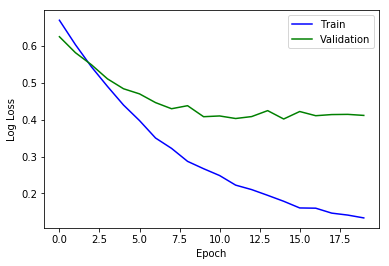

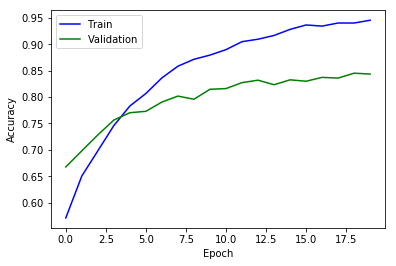

In [101]:
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='g')
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.legend(["Train", "Validation"])
plt.show()
plt.plot(history.history['acc'], color='b')
plt.plot(history.history['val_acc'], color='g')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

In [99]:
XtestTrue=np.array([Xtest[i] for i in range(Ytest.shape[0]) if Ytest[i,1]==1])
YtestTrue=np.array([Ytest[i] for i in range(Ytest.shape[0]) if Ytest[i,1]==1])
XtestFalse=np.array([Xtest[i] for i in range(Ytest.shape[0]) if Ytest[i,1]==0])
YtestFalse=np.array([Ytest[i] for i in range(Ytest.shape[0]) if Ytest[i,1]==0])

scoretrue=model.evaluate(XtestTrue,YtestTrue)
scorefalse=model.evaluate(XtestFalse,YtestFalse)

1483/1483 [==============================] - 8s     


In [100]:
print("Sensitivity:", 0.7477) #Evaluated from 2TrainUnet.ipynb
print("FP Rate/slice:", len(falseind)/(sum(slicecounts+slicecounts2)))
print("FP Rate/slice after nodule classification:", len(falseind)*(1-scorefalse[1])/(sum(slicecounts+slicecounts2)))
print("Sensitivity after nodule classification:", 0.7477*scoretrue[1])

Sensitivity: 0.7477
FP Rate/slice: 0.06030808390063514
FP Rate/slice after nodule classification: 0.0110205601612
Sensitivity after nodule classification: 0.650025277771
